In [1]:
import pickle
import numpy as np
from scipy.stats import entropy
from tqdm import tqdm
from datasets import load_dataset

/data/miniconda3/envs/exp-punpun0/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SelfCheckGPT
- NLI variant (fast)

In [2]:
import torch
from selfcheckgpt.modeling_selfcheck import SelfCheckNLI

/data/miniconda3/envs/exp-punpun0/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
selfcheck = SelfCheckNLI(device=device)

SelfCheck-NLI initialized to device cuda


## load `wiki_bio_gpt3_hallucination` data

In [5]:
dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")
dataset = dataset['evaluation']

In [6]:
label_mapping = {
    'accurate': 0.0,
    'minor_inaccurate': 0.5,
    'major_inaccurate': 1.0,
}

In [7]:
human_label_detect_False   = {}
human_label_detect_False_h = {}
human_label_detect_True    = {}
for i_ in range(len(dataset)):
    dataset_i = dataset[i_]
    idx = dataset_i['wiki_bio_test_idx']
    raw_label = np.array([label_mapping[x] for x in dataset_i['annotation']])
    human_label_detect_False[idx] = (raw_label > 0.499).astype(np.int32).tolist()
    human_label_detect_True[idx]  = (raw_label < 0.499).astype(np.int32).tolist()
    average_score = np.mean(raw_label)
    if average_score < 0.99:
        human_label_detect_False_h[idx] = (raw_label > 0.99).astype(np.int32).tolist()

In [8]:
len(human_label_detect_False), len(human_label_detect_True), len(human_label_detect_False_h)

(238, 238, 206)

# Experimental Setup

In [9]:
def unroll_pred(scores, indices):
    unrolled = []
    for idx in indices:
        unrolled.extend(scores[idx])
    return unrolled

In [10]:
def get_PR_with_human_labels(preds, human_labels, pos_label=1, oneminus_pred=False):
    indices = [k for k in human_labels.keys()]
    unroll_preds = unroll_pred(preds, indices)
    if oneminus_pred:
        unroll_preds = [1.0-x for x in unroll_preds]
    unroll_labels = unroll_pred(human_labels, indices)
    assert len(unroll_preds) == len(unroll_labels)
    print("len:", len(unroll_preds))
    P, R, thre = precision_recall_curve(unroll_labels, unroll_preds, pos_label=pos_label)
    return P, R

In [11]:
def print_AUC(P, R):
    print("AUC: {:.2f}".format(auc(R, P)*100))

In [12]:
indices = [x['wiki_bio_test_idx'] for x in dataset] 

In [13]:
selfcheck_scores = {} # sentence-level scores
for i in tqdm(range(len(dataset))):
    x = dataset[i]
    idx = dataset[i]['wiki_bio_test_idx']
    selfcheck_scores[idx] = selfcheck.predict(
        sentences = x['gpt3_sentences'],           # list of sentences
        sampled_passages = x['gpt3_text_samples'], # list of sampled passages
    ).tolist()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [11:09<00:00,  2.81s/it]


## Experiment1: Detecting False

In [14]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

In [15]:
# with human label, Detecting False
Prec, Rec = get_PR_with_human_labels(selfcheck_scores, human_label_detect_False, pos_label=1)
print("-----------------------")
print("SelfCheckGPT-NLI on WikiBio")
print_AUC(Prec, Rec)

len: 1908
-----------------------
SelfCheckGPT-NLI on WikiBio
AUC: 92.50


In [16]:
arr = []
for v in human_label_detect_False.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.7295597484276729

Text(0.5, 0, 'Recall')

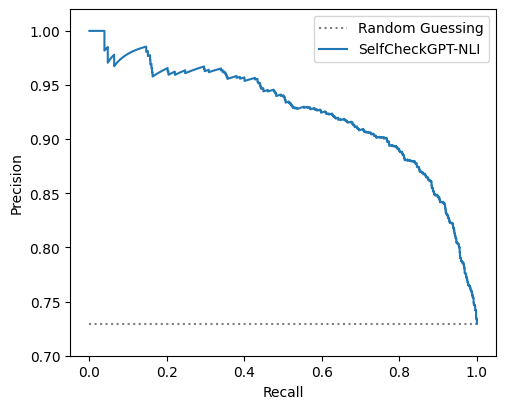

In [17]:
# with human label, Detecting Non-factual
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random Guessing') 
plt.plot(Rec, Prec, '-', label='SelfCheckGPT-NLI')
plt.legend()
plt.ylim(0.7,1.02)
plt.ylabel("Precision")
plt.xlabel("Recall")

## Experiment2: Detect False* (harder/less-trivial)

In [18]:
# with human label, Detecting False
Prec, Rec = get_PR_with_human_labels(selfcheck_scores, human_label_detect_False_h, pos_label=1)
print("-----------------------")
print("SelfCheckGPT-NLI on WikiBio")
print_AUC(Prec, Rec)

len: 1632
-----------------------
SelfCheckGPT-NLI on WikiBio
AUC: 45.17


In [19]:
arr = []
for v in human_label_detect_False_h.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.2971813725490196

Text(0.5, 0, 'Recall')

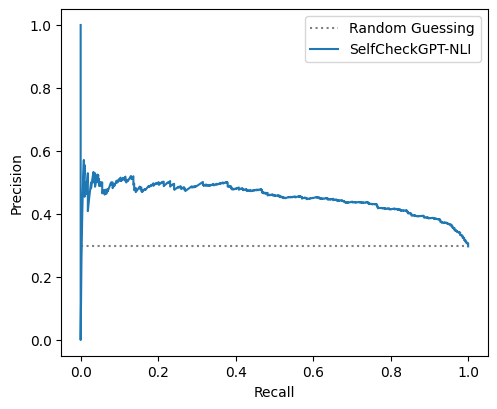

In [20]:
# with human label, Detecting Non-factual*
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random Guessing') 
plt.plot(Rec, Prec, '-', label='SelfCheckGPT-NLI')
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")

## Experiment3: Detecting True

In [21]:
# with human label, Detecting True
Prec, Rec = get_PR_with_human_labels(selfcheck_scores, human_label_detect_True, pos_label=1, oneminus_pred=True)
print("-----------------------")
print("SelfCheckGPT-NLI on WikiBio")
print_AUC(Prec, Rec)

len: 1908
-----------------------
SelfCheckGPT-NLI on WikiBio
AUC: 66.08


In [22]:
arr = []
for v in human_label_detect_True.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.27044025157232704

Text(0.5, 0, 'Recall')

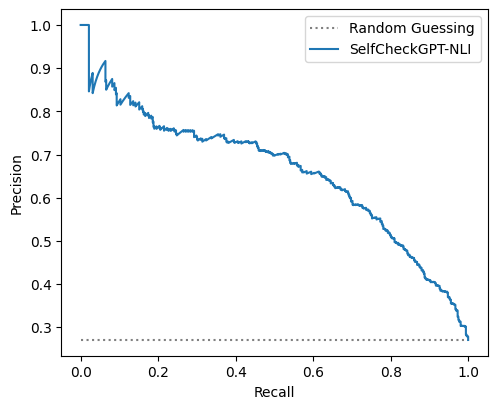

In [23]:
# with human label, Detecting Non-factual*
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random Guessing') 
plt.plot(Rec, Prec, '-', label='SelfCheckGPT-NLI')
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")